In [1]:
from datasets import load_dataset

from transformers import (
    SegformerForSemanticSegmentation, 
    SegformerImageProcessor,)

import torch
from torch import nn
from torch import optim

import numpy as np

import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda')

[Facade Dataset](https://huggingface.co/datasets/Xpitfire/cmp_facade)

In [2]:
DATA_PATH = "Xpitfire/cmp_facade"
facade_train = load_dataset(DATA_PATH, split="train")
facade_valid = load_dataset(DATA_PATH, split="eval")
facade_test = load_dataset(DATA_PATH, split="test")

Found cached dataset parquet (/home/m_bobrin/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/m_bobrin/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/m_bobrin/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [3]:
# Observe that label image is stored in P mode
facade_train[0]

{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=543x1024>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=P size=543x1024>}

## Inspecting Facade dataset 🏘

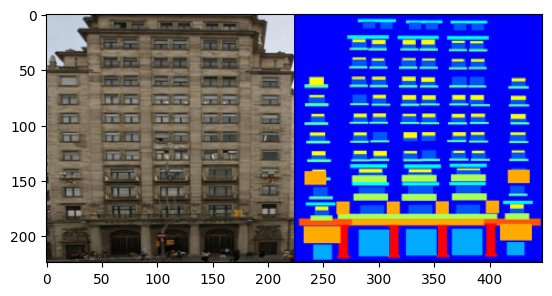

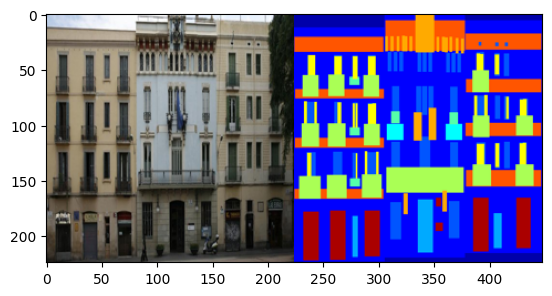

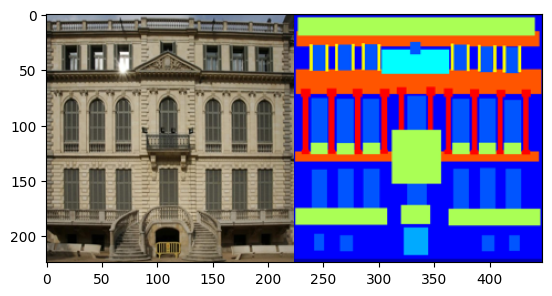

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

some_indexes = [0, 2, 3]
for i in some_indexes:
    stacked_img = Image.fromarray(
                np.hstack((facade_train[i]['pixel_values'].resize((224, 224)),
                         np.asarray(facade_train[i]['label'].convert("RGB").resize((224, 224))).reshape((224, 224, 3))
    )))
    
    plt.imshow(stacked_img)
    plt.show()

## Download config from repo 🤗 and Processing 

In [5]:
import json
from huggingface_hub import hf_hub_download

config = json.load(open(hf_hub_download(repo_id=DATA_PATH, filename="config.json", repo_type="dataset"), "r"))
id2label = config['id2label']
label2id = config['label2id']
COLOR_MAP = config['unique_colors']
COLOR_MAP

[[0, 0, 0],
 [0, 0, 170],
 [0, 0, 255],
 [0, 85, 255],
 [0, 170, 255],
 [0, 255, 255],
 [85, 255, 170],
 [170, 0, 0],
 [170, 255, 85],
 [255, 0, 0],
 [255, 85, 0],
 [255, 170, 0],
 [255, 255, 0]]

In [6]:
def facade_to_label(mask):
    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    
    for idx, label in enumerate(COLOR_MAP):
        label_mask[np.where(np.all(mask == label, axis=-1))] = idx #-1 since in PIL channel is last dimension
    label_mask = label_mask.astype(int)
    return label_mask

In [7]:
processor = SegformerImageProcessor()
jitter = transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 

def train_transform(batch):
    x = [jitter(x) for x in batch['pixel_values']]
    y = [facade_to_label(np.asarray(y.convert('RGB'))) for y in batch['label']]
    
    return processor(x, y, return_tensors='pt')

def eval_transform(batch):
    x = [x for x in batch['pixel_values']]
    y = [facade_to_label(np.asarray(y.convert('RGB'))) for y in batch['label']]
    return processor(x, y, return_tensors='pt')

facade_train.set_transform(train_transform)
facade_valid.set_transform(eval_transform)

In [8]:
def collate_fn(batch):
    x = [example['pixel_values'] for example in batch]
    y = [example['labels'] for example in batch]
    return torch.stack(x, 0), torch.stack(y, 0)

dummy_loader_train = DataLoader(facade_train, batch_size=2, shuffle=True, collate_fn=collate_fn)
dummy_loader_val = DataLoader(facade_valid, batch_size=2, shuffle=True, collate_fn=collate_fn)


In [9]:
pretrained_model_name = "nvidia/mit-b0" 
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.weight', 'de

In [10]:
xb, yb = next(iter(dummy_loader_train))
print(xb.shape, yb.shape)
out = model(facade_train[0]['pixel_values'].unsqueeze(0))

torch.Size([2, 3, 512, 512]) torch.Size([2, 512, 512])


In [11]:
model(xb)['logits'].shape

torch.Size([2, 13, 128, 128])

In [12]:
def upscale_logits(logit_outputs, res=512):
    return nn.functional.interpolate(
      logit_outputs,
      size=(res,res),
      mode='bilinear',
      align_corners=False
    )
#upscale_logits(model(xb)['logits']).shape

In [13]:
logits = upscale_logits(model(xb)['logits'])

In [14]:
logits.shape

torch.Size([2, 13, 512, 512])

In [15]:
#probs = probs.contiguous().view(probs.shape[0], -1).float()
#yb = yb.contiguous().view(yb.shape[0], -1).float()
#.unsqueeze(1).repeat(1, 13, 1, 1)
loss_fn = nn.CrossEntropyLoss()

loss_fn(
  logits,
  yb
)

tensor(2.5557, grad_fn=<NllLoss2DBackward0>)

In [16]:
device = torch.device("cuda:0")

In [17]:
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)
model=model.to(device)
lr = 1e-4 
n_epochs = 1000
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# move tensors into the current device
xb=xb.to(device)
yb=yb.to(device)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.weight', 'de

In [18]:
def decode_segmap(label_mask):
        label_colours = COLOR_MAP
        r = torch.zeros((label_mask.shape[0], label_mask.shape[1], label_mask.shape[-1]))
        g = torch.zeros((label_mask.shape[0], label_mask.shape[1], label_mask.shape[-1]))
        b = torch.zeros((label_mask.shape[0], label_mask.shape[1], label_mask.shape[-1]))
        
        for n_class in range(13):
            r[label_mask == n_class] = label_colours[n_class][0]
            g[label_mask == n_class] = label_colours[n_class][1]
            b[label_mask == n_class] = label_colours[n_class][2]
        res = torch.stack([r[:, None, ...], g[:, None, ...], b[:, None, ...]], dim=1).squeeze(2)
        return res

In [19]:
torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).shape

torch.Size([2, 512, 512])

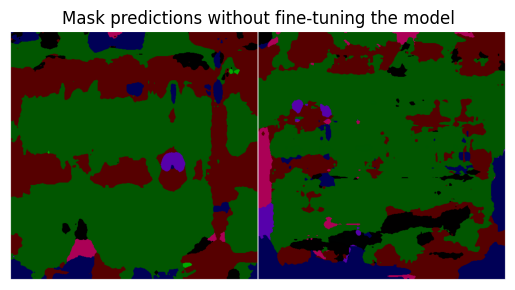

In [20]:
#@title
grid=torchvision.utils.make_grid(
    decode_segmap(torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).detach().cpu()),
    nrow=2,
    pad_value=8)

plt.imshow(np.uint8(grid.permute(1,2,0).numpy()) * 255);
plt.axis("off");
plt.title(f"Mask predictions without fine-tuning the model");

In [21]:
xb.shape

torch.Size([2, 3, 512, 512])

In [ ]:
lossi=np.zeros(n_epochs)

for idx in tqdm(range(n_epochs)):
    logits = model(xb)["logits"]
    logits= upscale_logits(model(xb)["logits"])
    optimizer.zero_grad()

    # Compute the loss
    loss = loss_fn(logits, yb)

    # store the current loss value
    cur_loss = loss.item()
    lossi[idx] = cur_loss

    #print(f"Loss at epoch {idx+1}: {cur_loss:.4f}")

    # Backward prop
    loss.backward()

    # Update the parameters
    optimizer.step()

    if idx%100== 0:
        print(f" -- Loss at epoch {idx}: {cur_loss:.4f}")

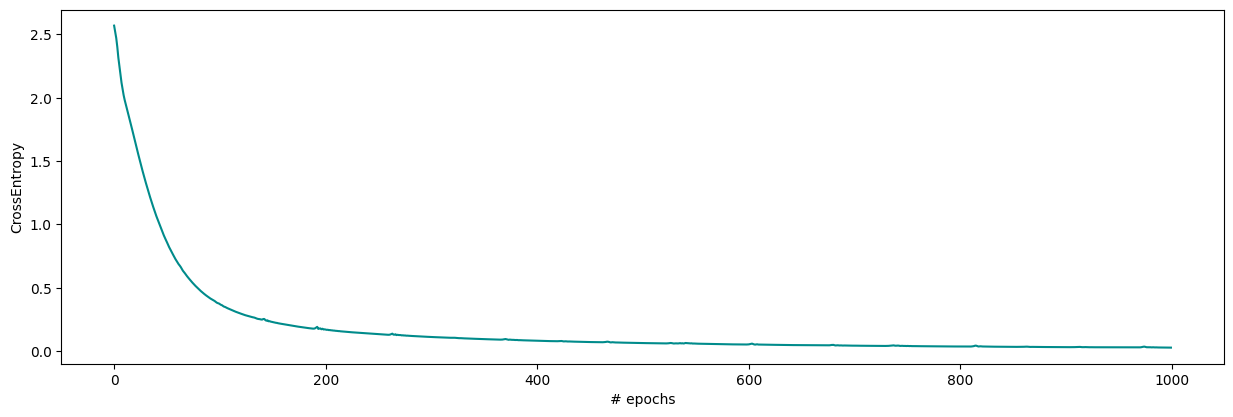

In [33]:
plt.figure(figsize=(15, 4.6));
plt.plot(lossi, color="darkcyan");
plt.xlabel("# epochs");
plt.ylabel("CrossEntropy");

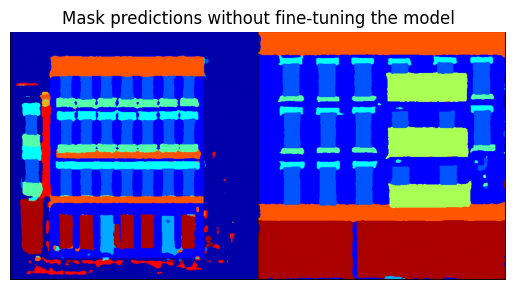

In [33]:
grid=torchvision.utils.make_grid(
    decode_segmap(torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).detach().cpu()),
    nrow=2,
    pad_value=8)

plt.imshow(np.uint8(grid.permute(1,2,0).numpy()) / 255);
plt.axis("off");
plt.title(f"Mask predictions without fine-tuning the model");


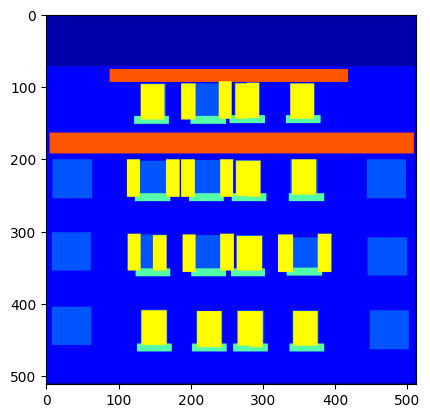

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [32]:
plt.imshow(np.uint8(decode_segmap(yb)[1].detach().cpu().numpy().transpose(1, 2,0)) / 255)

## Computing metrics

In [22]:
class CellSegmentation:
    def __init__(self, tfms: dir = None):
        self.repo_name = "Xpitfire/cmp_facade"
        self.train_ds = load_dataset(self.repo_name, split="train")
        self.valid_ds = load_dataset(self.repo_name, split="eval")
        self.test_ds = load_dataset(self.repo_name, split="test")
    
        if tfms:
            self.train_ds.set_transform(tfms["train"])
            self.valid_ds.set_transform(tfms["valid"])
            self.test_ds.set_transform(tfms["valid"])

    def get_dataloaders(self, bs=4, collate_fn=None, num_workers=2):
        train_dl = DataLoader(self.train_ds, batch_size=bs, shuffle=True,
                              collate_fn=collate_fn,
                              num_workers=num_workers)
        valid_dl = DataLoader(self.valid_ds, batch_size=1, shuffle=True,
                            collate_fn=collate_fn,
                            num_workers=num_workers)
        test_dl = DataLoader(self.test_ds, batch_size=bs, shuffle=True,
                             collate_fn=collate_fn,
                             num_workers=num_workers)
        return train_dl, valid_dl, test_dl

In [23]:
processor = SegformerImageProcessor()
jitter = transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 

def train_transform(batch):
    x = [jitter(x) for x in batch['pixel_values']]
    y = [facade_to_label(np.asarray(y.convert('RGB'))) for y in batch['label']]
    
    return processor(x, y, return_tensors='pt')

def eval_transform(batch):
    x = [x for x in batch['pixel_values']]
    y = [facade_to_label(np.asarray(y.convert('RGB'))) for y in batch['label']]
    return processor(x, y, return_tensors='pt')

tfms={"train": train_transform, "valid": eval_transform}

datasets = CellSegmentation(tfms=tfms)

Found cached dataset parquet (/home/m_bobrin/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/m_bobrin/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/m_bobrin/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [24]:
import multiprocessing as mp
mp.cpu_count()

40

In [25]:
train_dl, valid_dl, test_dl = datasets.get_dataloaders(collate_fn=collate_fn, num_workers=20)
print(next(iter(train_dl))[0].shape, next(iter(train_dl))[1].shape)

torch.Size([4, 3, 512, 512]) torch.Size([4, 512, 512])


# 🐝 Wandb

In [26]:
import wandb

project = 'SegFormer_Facade'
batch_size = 4
lr = 3e-4
#lr_scheduler = 0.9
epochs = 10

wandb.init(project=project, config={"epochs": epochs, "batch_size": batch_size, "lr": lr})

# Add additional configs to wandb if needed
wandb.config['len_train'] = len(datasets.train_ds)
wandb.config['len_val'] = len(datasets.valid_ds)

wandb: Currently logged in as: simmax21. Use `wandb login --relogin` to force relogin


In [35]:
def validate_model(model, valid_dl, loss_fn, log_images=True):
    model.eval()
    
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        
        for i, (images, masks) in enumerate(valid_dl):
            images, masks = images.to(device), masks.to(device)
            logits = upscale_logits(model(images)["logits"])
            val_loss+= loss_fn(logits, masks).item()*masks.size(0)
    
            predicted = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            #plt.imshow(np.uint8(decode_segmap(predicted)[0].detach().numpy().transpose(1, 2, 0)) / 255)
            #plt.show()
            correct += (predicted == masks).sum().item()

            if log_images:
                if i == 0:
                    table = wandb.Table(columns=["image", "mask", "pred_mask"])
                    for img, mask, pred in zip(images.to("cpu"), masks.to("cpu"),
                                                                 predicted.to("cpu")):
                        #plt.imshow(np.uint8(decode_segmap(predicted)[0].detach().numpy().transpose(1, 2, 0)) / 255)
                        #plt.show()
                        plt.axis("off")
                        plt.tight_layout()
                        table.add_data(wandb.Image(img.permute(1,2,0).numpy()), 
                                       wandb.Image(np.uint8(decode_segmap(mask.unsqueeze(0)).squeeze(0).detach().numpy().transpose(1, 2, 0)) / 255),
                                       wandb.Image(np.uint8(decode_segmap(predicted)[0].detach().numpy().transpose(1, 2, 0)) / 255),
                                       )
            if log_images:
                wandb.log({"val_table/predictions_table":table}, commit=False)

    return (
        val_loss / len(valid_dl.dataset), 
        correct / (len(valid_dl.dataset)*512**2),
    )

In [ ]:
import math

config = wandb.config

n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.lr_scheduler)

example_ct = 0
step_ct = 0
max_iou = 0.0
epochs = 10
LOG_IMAGES = True
MODEL_NAME = pretrained_model_name

for epoch in tqdm(range(epochs)):
    model.train()
    for step, (images, masks) in tqdm(enumerate(train_dl), leave=False):
        images, masks = images.to(device), masks.to(device)
        logits = upscale_logits(model(images)["logits"])
        train_loss = loss_fn(logits, masks)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        example_ct += len(images)
        metrics = {"train/train_loss": train_loss, 
                   "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
                   "train/example_ct": example_ct}#scheduler.state_dict()["_last_lr"][0]}

        if step + 1 < n_steps_per_epoch:
            wandb.log(metrics)
        step_ct += 1
        #scheduler.step()

        val_loss, accuracy = validate_model(model, valid_dl, loss_fn, log_images=True)      
        val_metrics = {"val/val_loss": val_loss, 
                     "val/val_accuracy": accuracy}
        wandb.log({**metrics, **val_metrics})

    print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:.3f}, Valid Accuracy: {accuracy:.2f}")

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.929, Valid Loss: 1.148, Valid Accuracy: 0.60


0it [00:00, ?it/s]

Train Loss: 0.771, Valid Loss: 1.049, Valid Accuracy: 0.63


0it [00:00, ?it/s]

Train Loss: 0.490, Valid Loss: 1.020, Valid Accuracy: 0.64


0it [00:00, ?it/s]